In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

from functions import missing_data_df, modify_features, encode_ordinal, impute_null, add_location

#sns.set_style('whitegrid')
sns.set_palette('Paired')

import plotly.io as pio
pio.renderers.default = "svg"

## Loading the data

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# Load the data
df = pd.read_csv('data/Ames_Housing_Price_Data.csv', index_col=0).iloc[:,1:]
print('df shape:', df.shape)

df['PriceSF'] = df.SalePrice / df.GrLivArea
df = df[df.SaleCondition == 'Normal']

df shape: (2580, 80)


In [4]:
# Save 2010 data for predicting
print(df.YrSold.value_counts(normalize=True))

df_2010 = df[df['YrSold']==2010].reset_index(drop=True)
df = df[df['YrSold']<2010].reset_index(drop=True)

2009    0.232394
2007    0.229909
2008    0.220795
2006    0.192212
2010    0.124689
Name: YrSold, dtype: float64


## Missing data

In [5]:
# Check for missing values
missing_data_df(df)

,Count,Percent
PoolQC,2104,99.574065
MiscFeature,2037,96.403218
Alley,1975,93.469001
Fence,1679,79.460483
FireplaceQu,1002,47.420729
LotFrontage,405,19.167061
GarageYrBlt,97,4.590629
GarageFinish,97,4.590629
GarageQual,97,4.590629
GarageCond,97,4.590629


In [6]:
# We will drop the PoolQC and PoolArea features since more that 99% of houses don't have a pool.
df.drop(columns=['PoolQC', 'PoolArea'], inplace=True)

### Imputing null values

In [7]:
df = impute_null(df)
df_2010 = impute_null(df_2010)

## EDA

##### Numerical Features:

`['SalePrice', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 
                      'BsmtFinSF2', 'BsmtUnfSF',  'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
                      'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
                      'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal']`

##### Discrete Features:

`['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
                     'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
                     'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold', 'MSSubClass']`

##### Nominal Features:

`['MSZoning', 'Street', 'LandContour', 'LotConfig', 'Neighborhood', 
                    'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
                    'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 
                    'GarageType', 'SaleType']`

##### Ordinal Features:

`['LotShape', 'Utilities', 'LandSlope','ExterQual', 'ExterCond', 'BsmtQual', 
                    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
                    'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 
                    'GarageQual', 'GarageCond', 'PavedDrive', 'OverallQual', 'OverallCond']`

## Feature Engineering

#### Modify Features

In [8]:
# Create HouseAge and RemodAge feature.
# Modify features with categories with very few data points.
# Binarize features where only a few categories appear to be correlated to SalesPrice.
df = modify_features(df)
df_2010 = modify_features(df_2010)

In [9]:
# Encode ordinal features into numbers.
df = encode_ordinal(df)
df_2010 = encode_ordinal(df_2010)

#### Create New Features

In [10]:
# Create a Location features
df['Location'] = df.Neighborhood.map(add_location)
df_2010['Location'] = df_2010.Neighborhood.map(add_location)

#### Dumify Features

In [11]:
# Dummies Location
df = pd.get_dummies(df
               ,columns = ['Location']
               ,drop_first = True
               )

df_2010 = pd.get_dummies(df_2010
               ,columns = ['Location']
               ,drop_first = True
               )


# Dummies Dwell Type
df = pd.get_dummies(df
               ,columns = ['BldgType']
               ,drop_first = True
               )

df_2010 = pd.get_dummies(df_2010
               ,columns = ['BldgType']
               ,drop_first = True
               )


# Model

In [12]:
feature_selection = ['ExterQual', 'BsmtQual', 'KitchenQual', 'OverallQual', 'GarageCars',
                        'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'GarageArea', 'FullBath', 
                        #'HouseAge', 
                        'TotRmsAbvGrd', '2ndFlrSF', 
                        'OverallCond', 'ExterCond', 'Location_2', 'Location_3', 
                        'Location_4', 'Fireplaces', 'LotFrontage', 
                        'Zone', 
                        'LotArea',
                        'MSSubClass', 'GoodGarageType', 'BsmtUnfSF', 'YearBuilt']
                        

In [13]:
df

,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,Foundation,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,PriceSF,HouseAge,RemodAge,GoodGarageType,Zone,ExterQual,BsmtQual,KitchenQual,ExterCond,Location_2,Location_3,Location_4,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE
0,1049,139500,120,RL,42.00000,4235,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Story,5,5,1984,1984,Gable,CompShg,HdBoard,HdBoard,BrkFace,149.0,CBlock,TA,Mn,GLQ,552.0,ALQ,393.0,104.0,1049.0,GasA,TA,Y,SBrkr,1049,0,0,1.0,0.0,2,0,2,1,5,Typ,0,None,Attchd,1984.0,Fin,1.0,266.0,TA,TA,Y,0,105,0,0,0,None,None,0,2,2009,WD,Normal,132.983794,25,25,1.0,1.0,2.0,3.0,3.0,2.0,0,0,0,0,0,0,1
1,1001,124900,30,C (all),60.00000,6060,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Story,5,9,1930,2007,Hip,CompShg,MetalSd,MetalSd,None,0.0,BrkTil,TA,No,ALQ,737.0,Unf,0.0,100.0,837.0,GasA,Ex,Y,SBrkr,1001,0,0,0.0,0.0,1,0,2,1,5,Typ,0,None,Detchd,1930.0,Unf,1.0,216.0,TA,Po,N,154,0,42,86,0,None,None,0,11,2007,WD,Normal,124.775225,77,0,0.0,0.0,2.0,2.0,3.0,2.0,0,0,0,0,0,0,0
2,1039,114000,70,RL,80.00000,8146,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,2Story,4,8,1900,2003,Gable,CompShg,MetalSd,MetalSd,None,0.0,BrkTil,TA,No,Unf,0.0,Unf,0.0,405.0,405.0,GasA,Gd,Y,SBrkr,717,322,0,0.0,0.0,1,0,2,1,6,Typ,0,None,Detchd,1940.0,Unf,1.0,281.0,TA,TA,N,0,0,168,0,111,None,None,0,5,2009,WD,Normal,109.720885,109,6,0.0,1.0,2.0,1.0,2.0,3.0,0,0,0,0,0,0,0
3,1665,227000,60,RL,70.00000,8400,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,2Story,8,6,2001,2001,Gable,CompShg,VinylSd,VinylSd,None,0.0,PConc,TA,No,GLQ,643.0,Unf,0.0,167.0,810.0,GasA,Ex,Y,SBrkr,810,855,0,1.0,0.0,2,1,3,1,6,Typ,0,None,Attchd,2001.0,Fin,2.0,528.0,TA,TA,Y,0,45,0,0,0,None,None,0,11,2009,WD,Normal,136.336336,8,8,1.0,1.0,2.0,3.0,3.0,2.0,1,0,0,0,0,0,0
4,1922,198500,85,RL,64.00000,7301,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Edwards,Norm,Norm,SFoyer,7,5,2003,2003,Gable,CompShg,HdBoard,HdBoard,BrkFace,500.0,Slab,None,None,None,0.0,None,0.0,0.0,0.0,GasA,Ex,Y,SBrkr,495,1427,0,0.0,0.0,3,0,4,1,7,Typ,1,Ex,BuiltIn,2003.0,RFn,2.0,672.0,TA,TA,Y,0,0,177,0,0,None,None,0,7,2009,ConLD,Normal,103.277836,6,6,1.0,1.0,2.0,0.0,3.0,2.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2108,952,121000,30,RL,68.21897,8854,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1.5Unf,6,6,1916,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,BrkTil,TA,No,Unf,0.0,Unf,0.0,952.0,952.0,Grav,Fa,N,FuseF,952,0,0,0.0,0.0,1,0,2,1,4,Typ,1,Gd,Detchd,1916.0,Unf,1.0,192.0,Fa,Po,P,0,98,0,0,40,None,None,0,5,2009,WD,Normal,127.100840,93,59,0.0,1.0,1.0,2.0,1.0,2.0,0,0,0,0,0,0,0
2109,1733,139600,20,RL,68.21897,13680,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Edwards,Norm,Norm,1Story,3,5,1955,1955,Hip,CompShg,BrkFace,Wd Sdng,None,0.0,Slab,None,None,None,0.0,None,0.0,0.0,0.0,GasA,Ex,Y,FuseA,1733,0,0,0.0,0.0,2,0,4,1,8,Min2,1,Gd,Attchd,1955.0,Unf,2.0,452.0,TA,TA,Y,0,0,0,0,0,None,None,0,6,2009,WD,Normal,80.553953,54,54,1.0,1.0,1.0,0.0,2.0,2.0,0,0,0,0,0,0,0
2110,2002,145000,90,R

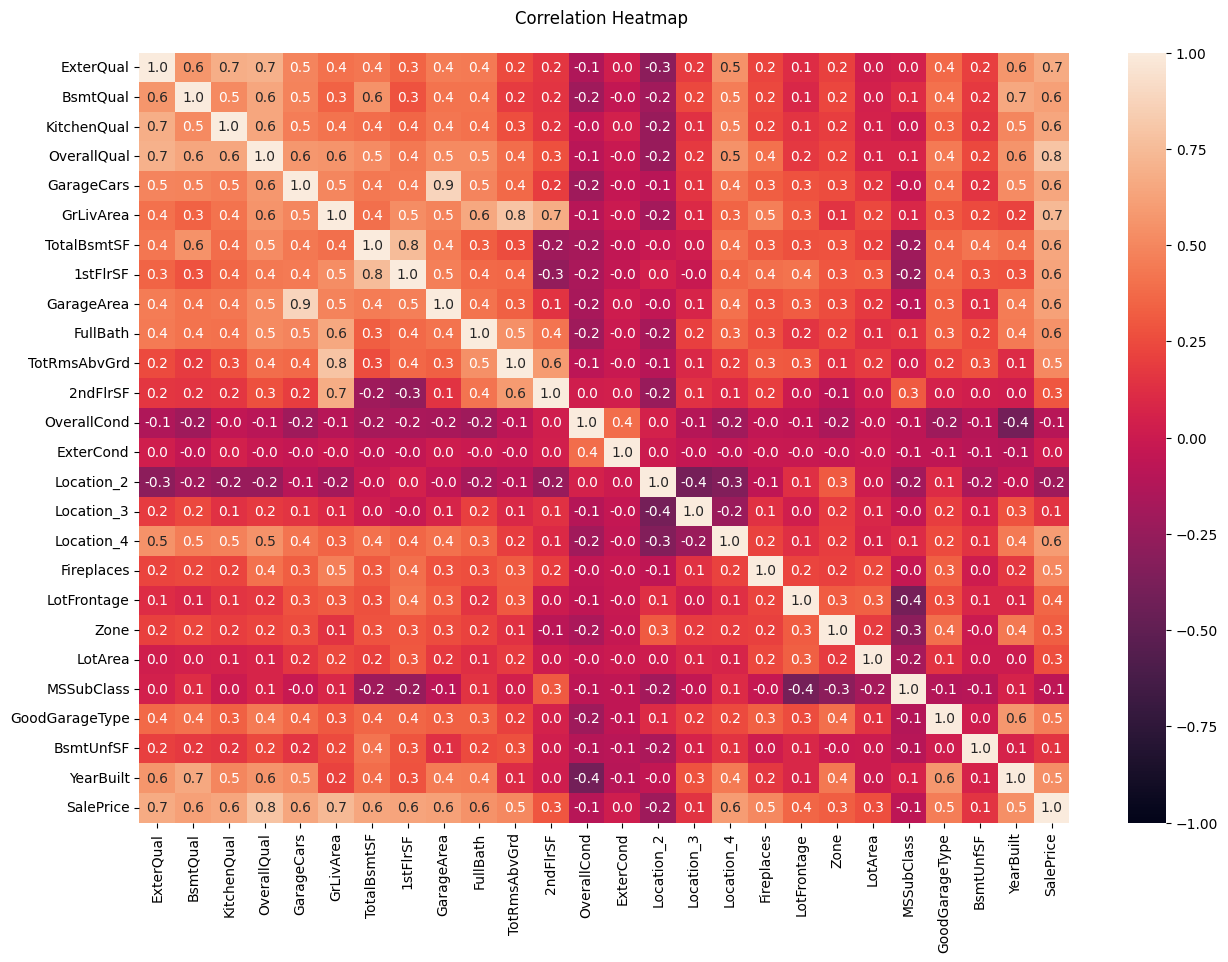

In [14]:
plt.figure(figsize=(15, 10))

corr_mat = df[feature_selection + ['SalePrice']].corr()
high_corr_mat = corr_mat[abs(corr_mat) >= 0]
#cmap = sns.diverging_palette(250, 10, as_cmap=True)

sns.heatmap(high_corr_mat,
            annot=True,
            fmt='.1f',
            vmin=-1,
            vmax=1,
            #cmap=cmap
            )
title = plt.title('Correlation Heatmap \n')

In [15]:
df = df.reset_index(drop=True)
df_2010 = df_2010.reset_index(drop=True)

scaler = StandardScaler()

X_train = df[feature_selection]
y_train = np.log(df['SalePrice'])

X_test= df_2010[feature_selection]
y_test = np.log(df_2010['SalePrice'])

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## Linear Regression

In [16]:
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)

kf = KFold(n_splits=5, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(ols, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(ols, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(ols, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.9056 0.9279 0.9272 0.931  0.9416]
Mean shuffled cross validation score: 0.9267
RMSE Shuffled cross validation score: [0.1073 0.1043 0.0981 0.1013 0.0902]
RMSE Mean shuffled cross validation score: 0.1002


In [17]:
test_score = ols.score(X_test_scaled, y_test)

print('Test score:', np.round(test_score, 4))

rms = mean_squared_error(y_test, ols.predict(X_test_scaled), squared=False)
print('RMSE Test score:', np.round(rms, 4))

Test score: 0.9187
RMSE Test score: 0.1019


In [18]:
yhat_train = ols.predict(X_train_scaled)
yhat_test = ols.predict(X_test_scaled)

train_mse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_mse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_mse_non_log)
print(test_mse_non_log)

17678.171380163178
17771.91495169938


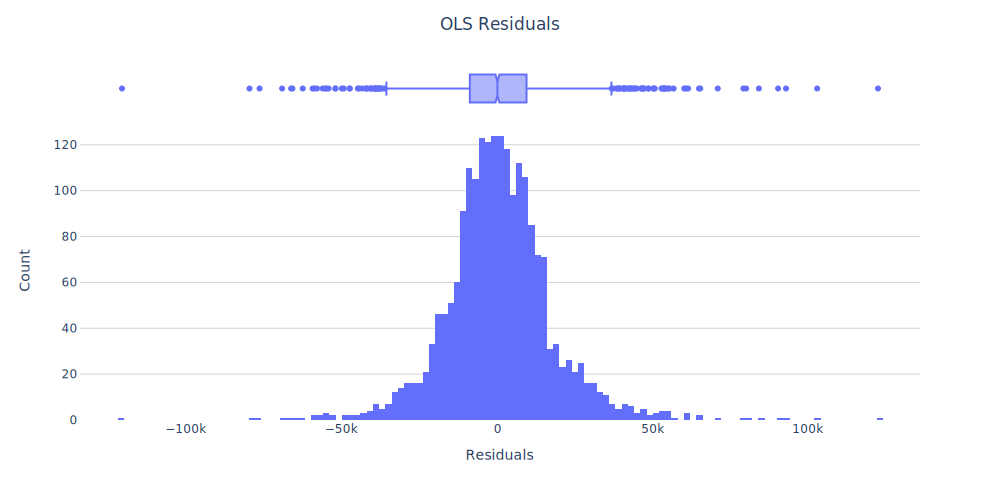

In [19]:
yhat = ols.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                df, 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])

#Plot
fig = px.histogram(
                results, 
                x="residual",
                marginal="box",
                width=1000)

fig.update_layout(
                title='OLS Residuals', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Residuals",
                row=1, col=1)

fig.show()

((array([-3.40734933, -3.15732323, -3.01870147, ...,  3.01870147,
          3.15732323,  3.40734933]),
  array([-0.78215087, -0.65723397, -0.55892387, ...,  0.46363718,
          0.50362215,  0.51700211])),
 (0.09736108955090708, -1.233019747570319e-15, 0.9822563774142054))

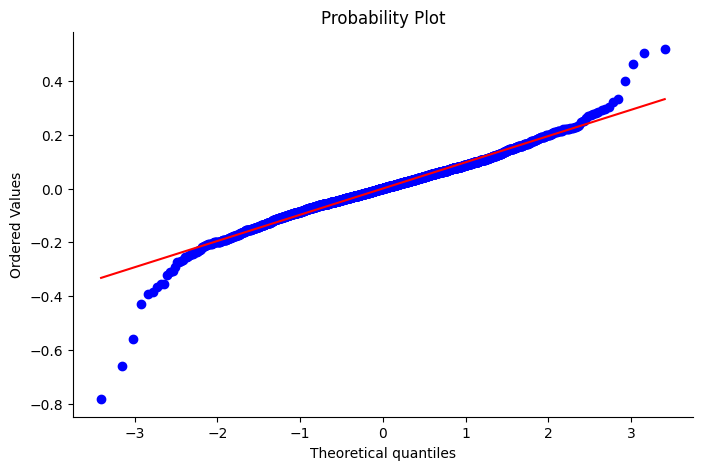

In [20]:
fig, ax = plt.subplots(figsize=(8,5))
sns.despine()

stats.probplot(residuals, dist="norm", plot=plt)

In [21]:
res = stats.shapiro(residuals)
res.statistic

0.9665647149085999

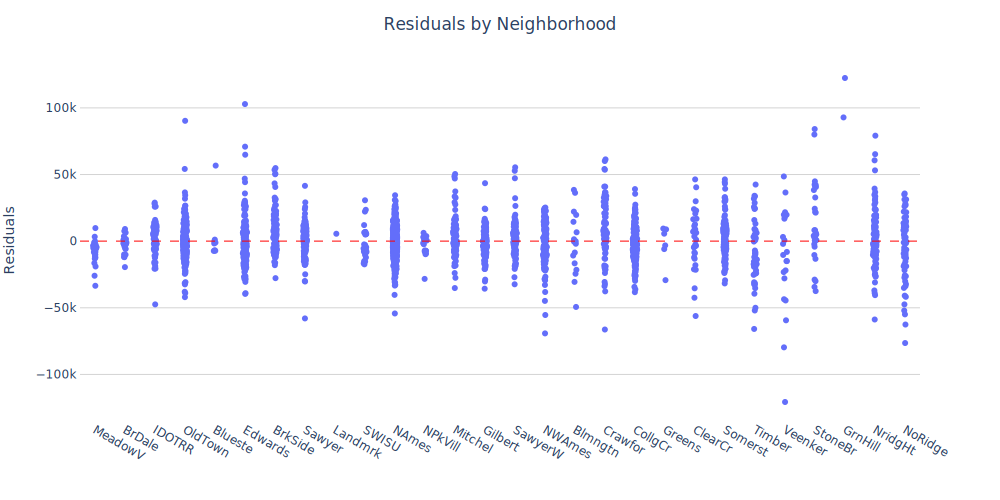

In [22]:
order = results.groupby('Neighborhood').SalePrice.median().sort_values().index

fig = px.strip(
            results, 
            x='Neighborhood', 
            y='residual',
            category_orders={'Neighborhood':order},
            width=1000)
fig.update_layout(
            title='Residuals by Neighborhood', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')
fig.update_yaxes(
            showline=True,
            gridcolor='lightgray',
            title="Residuals")
fig.update_xaxes(
            title=None)
fig.add_hline(y=40, line_width=1, line_dash="dash", line_color="red")
fig.show()

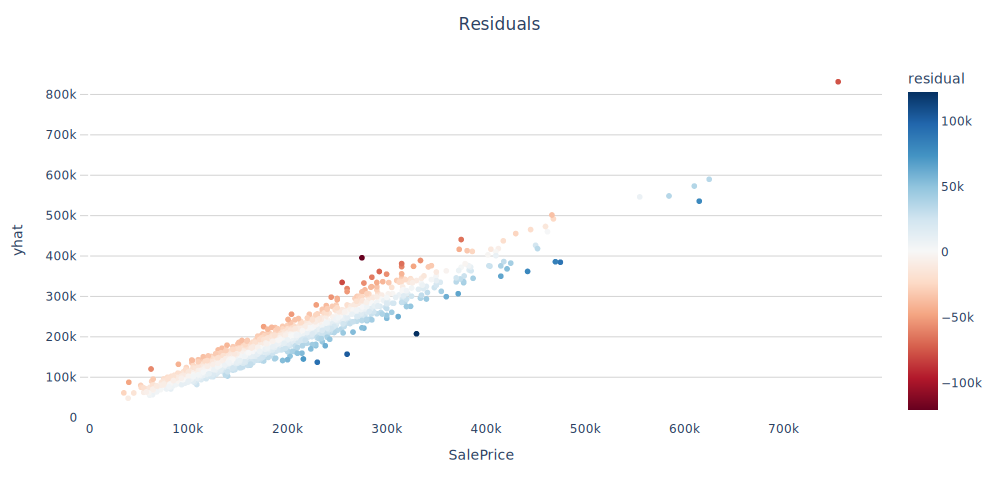

In [23]:
fig = px.scatter(
            results, 
            x='SalePrice', 
            y='yhat',
            color='residual',
            color_continuous_scale='RdBu',
            width=1000)
fig.update_layout(
            title='Residuals', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')
fig.update_yaxes(
            showline=True,
            gridcolor='lightgray')
fig.show()

## Lasso

In [24]:
# Create the LassoCV model
lasso = LassoCV(cv=3)  # Set the number of cross-validation folds

# Fit the LassoCV model
lasso.fit(X_train_scaled, y_train)

# Get the best alpha value
best_alpha = lasso.alpha_

# Print the best alpha value
print('Best alpha:', best_alpha)

# Predict on the test set
y_pred = lasso.predict(X_test_scaled)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)


Best alpha: 0.00030416951022080486
RMSE: 0.10181646185306278


In [25]:
kf = KFold(n_splits=5, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(lasso, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(lasso, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(lasso, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.9056 0.928  0.9274 0.9301 0.9414]
Mean shuffled cross validation score: 0.9265
RMSE Shuffled cross validation score: [0.1073 0.1042 0.098  0.1019 0.0904]
RMSE Mean shuffled cross validation score: 0.1003


In [26]:
yhat_train = lasso.predict(X_train_scaled)
yhat_test = lasso.predict(X_test_scaled)

train_mse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_mse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_mse_non_log)
print(test_mse_non_log)

17645.939552193868
17765.801884830606


In [27]:
X_train_prov = X_train_scaled.copy()
X_train_prov['SalePrice'] = y_train
X_train_prov = X_train_prov[(df['OverallQual']>7)].reset_index(drop=True)

X_test_prov = X_test_scaled.copy()
X_test_prov['SalePrice'] = y_test
X_test_prov = X_test_prov[ (df_2010['OverallQual']>7)].reset_index(drop=True)


yhat_train = lasso.predict(X_train_prov.drop(columns='SalePrice'))
yhat_test = lasso.predict(X_test_prov.drop(columns='SalePrice'))

train_mse_non_log = mean_squared_error(np.exp(X_train_prov['SalePrice']), np.exp(yhat_train), squared=False)
test_mse_non_log = mean_squared_error(np.exp(X_test_prov['SalePrice']), np.exp(yhat_test), squared=False)

print(train_mse_non_log)
print(test_mse_non_log)

26111.349629009404
25383.60170433119


In [28]:
yhat = lasso.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                df, 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])